In [11]:
import numpy as np
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

import keijzer_exogan as ke

from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

from sklearn.metrics import r2_score

%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"} # Make sure the axis background of plots is white, this is usefull for the black theme in JupyterLab

# Initialize default seaborn layout
sns.set_palette(sns.hls_palette(8, l=.3, s=.8))
sns.set(style='ticks') 

In [12]:
df = pd.read_csv('Validation error of 25 images')
df.head()

,Unnamed: 0,planet_mass_error,temp_profile_error,ch4_mixratio_error,planet_radius_error,h2o_mixratio_error,co2_mixratio_error,co_mixratio_error,planet_mass_real,temp_profile_real,...,h2o_mixratio_real,co2_mixratio_real,co_mixratio_real,planet_mass_inpainted,temp_profile_inpainted,ch4_mixratio_inpainted,planet_radius_inpainted,h2o_mixratio_inpainted,co2_mixratio_inpainted,co_mixratio_inpainted
0,0,-28.147485,50.566719,181.090414,28.656775,347.494268,-110.465000,-103.322522,2.277600e+27,1444.444448,...,-2.302585,-5.884384,-16.629781,1.636513e+27,2174.852610,-11.506392,1.209264e+08,-10.303936,0.615801,0.552528
1,0,-6.946719,123.753452,399.445182,22.735093,-35.619915,-104.514345,-58.120570,1.771467e+27,1000.000000,...,-16.629781,-18.420681,-11.257083,1.648408e+27,2237.534523,-11.500150,1.153605e+08,-10.706267,0.831573,-4.714402
2,0,-50.133269,25.895544,-36.159443,103.032148,341.304165,-133.979293,-82.044487,3.289867e+27,1666.666687,...,-2.302585,-5.884384,-16.629781,1.640549e+27,2098.259091,-8.329904,1.135534e+08,-10.161404,1.999472,-2.985962
3,0,-40.492477,40.288543,113.030896,24.095082,-9.808643,-96.994001,89.080143,2.783733e+27,1444.444448,...,-11.257083,-16.629781,-2.302585,1.656531e+27,2026.390076,-12.535555,1.166388e+08,-10.152916,-0.499891,-4.353731
4,0,-40.041560,14.046226,-49.397437,64.473327,13.957760,-114.194130,-77.295776,2.783733e+27,1777.777791,...,-11.257083,-4.093484,-5.884384,1.669083e+27,2027.488470,-9.321337,1.188178e+08,-12.828319,0.581034,-1.336004


In [13]:
df.describe()

,Unnamed: 0,planet_mass_error,temp_profile_error,ch4_mixratio_error,planet_radius_error,h2o_mixratio_error,co2_mixratio_error,co_mixratio_error,planet_mass_real,temp_profile_real,...,h2o_mixratio_real,co2_mixratio_real,co_mixratio_real,planet_mass_inpainted,temp_profile_inpainted,ch4_mixratio_inpainted,planet_radius_inpainted,h2o_mixratio_inpainted,co2_mixratio_inpainted,co_mixratio_inpainted
count,24.0,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,2.400000e+01,24.000000,...,24.000000,24.000000,24.000000,2.400000e+01,24.000000,24.000000,2.400000e+01,24.000000,24.000000,24.000000
mean,0.0,-29.931515,52.231736,97.696674,57.622972,106.299006,-105.088567,-94.737026,2.562300e+27,1472.222233,...,-8.496113,-11.406324,-11.257083,1.644827e+27,2139.836247,-11.402852,1.159524e+08,-12.706163,-0.371808,-0.240419
std,0.0,21.573406,36.633870,147.010127,29.224558,137.205175,24.591534,51.644969,7.474180e+26,297.150546,...,4.157624,5.536739,5.201255,2.066101e+25,104.164649,2.110248,6.195430e+06,2.201653,1.949098,2.860055
min,0.0,-57.944334,-0.368041,-52.953814,16.623656,-35.619915,-168.536901,-177.305423,1.518400e+27,1000.000000,...,-16.629781,-18.420681,-18.420681,1.596433e+27,1984.291792,-14.959368,1.047500e+08,-17.331544,-5.085278,-6.538508
25%,0.0,-50.190044,24.229291,-23.721580,27.813723,17.482315,-111.397283,-118.460629,1.771467e+27,1222.222224,...,-11.257083,-16.629781,-16.629781,1.629029e+27,2040.796071,-12.587459,1.134233e+08,-13.180856,-1.493073,-1.934870
50%,0.0,-31.720318,42.439003,40.601196,67.109282,39.565557,-96.976855,-103.024380,2.404133e+27,1555.555582,...,-9.466183,-11.257083,-11.257083,1.644266e+27,2154.029787,-11.503271,1.157934e+08,-12.577985,-0.476816,0.387832
75%,0.0,-7.909653,70.691229,192.954474,76.037058,135.547808,-88.871703,-80.857310,3.289867e+27,1666.666687,...,-5.884384,-5.884384,-7.227559,1.658257e+27,2225.205362,-10.217486,1.193951e+08,-10.875485,0.848488,1.865673
max,0.0,8.430947,123.753452,399.445182,103.032148,444.338420,-72.393649,89.080143,3.796000e+27,2000.000000,...,-2.302585,-2.302585,-2.302585,1.680468e+27,2326.651812,-6.138578,1.313815e+08,-10.152916,3.556734,4.548948


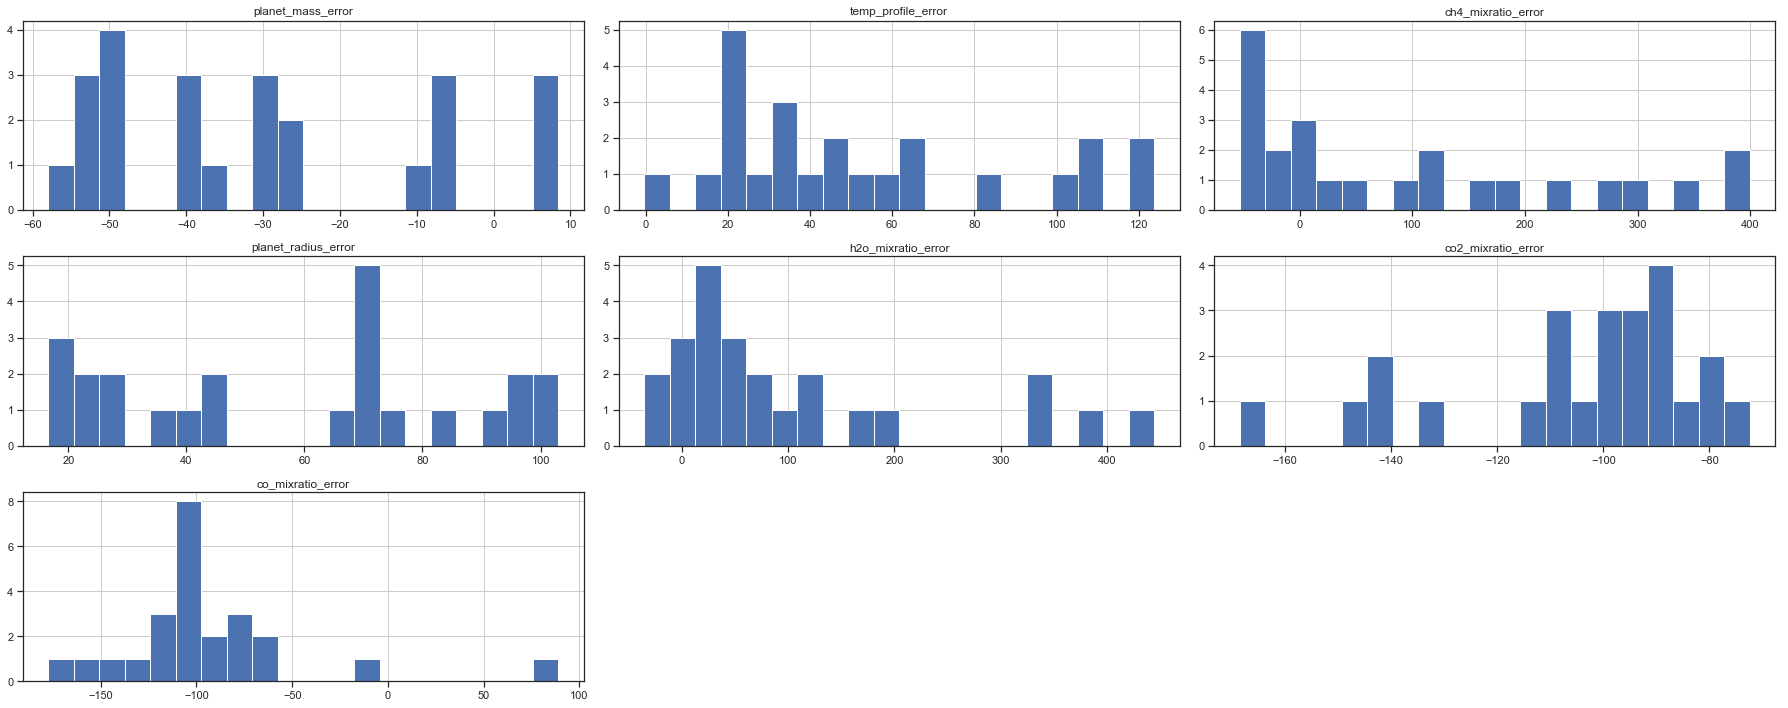

In [14]:
params = ['planet_mass','temp_profile','ch4_mixratio','planet_radius','h2o_mixratio','co2_mixratio','co_mixratio']

plt.figure(figsize=((25,10)))
for i,param in enumerate(params):
    plt.subplot(3,3,i+1)
    plt.title(param+'_error')
    plt.hist(df[param+'_error'], bins=20)
    plt.grid()
    plt.tight_layout()

# Grab the $n$ sigma errors

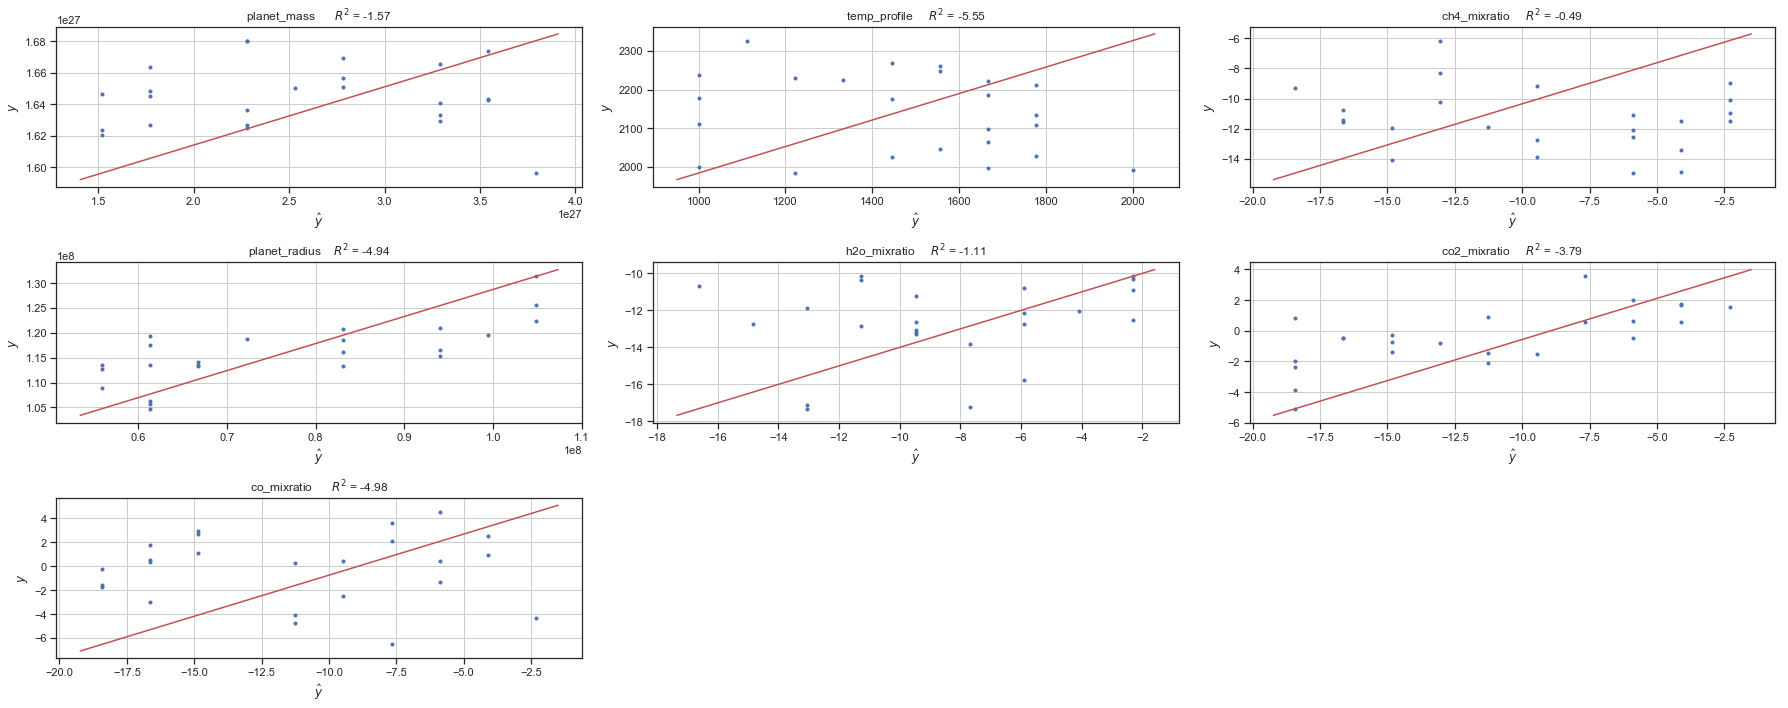

In [15]:
plt.figure(figsize=((25,10)))

for i,param in enumerate(params):
    y_hat = df[param+'_real']
    y = df[param+'_inpainted']
    
    r2 = r2_score(y_hat, y)
    
    plt.subplot(3,3,i+1)

    plt.title(param +' \t $R^2$ = %.2f' % r2)
    plt.plot(y_hat, y, '.')
    #plt.ylim(plt.xlim()) # set y axis range the same as x axis range
    plt.plot(plt.xlim(), plt.ylim(), ls="-", c='r')
    
    plt.xlabel(r"$\hat{y}$")
    plt.ylabel(r"$y$")
    plt.grid()
    plt.tight_layout()

In [16]:
# Error per parameter

In [17]:
params

['planet_mass',
 'temp_profile',
 'ch4_mixratio',
 'planet_radius',
 'h2o_mixratio',
 'co2_mixratio',
 'co_mixratio']

In [18]:
param = params[6]
print('Param: ', param)

uniques = df[param+'_real'].unique()
print('Uniques: ',uniques)

Param:  co_mixratio
Uniques:  [-16.62978126 -11.25708265  -2.302585    -5.88438368  -7.67528397
 -18.42068074  -9.46618331 -14.8388818   -4.09348434]


4 12.261451376226992
3 24.311131867555257
1 nan
3 51.301486567504334
3 71.271059742373
3 4.503480695715499
2 22.07807732466762
3 6.820227170950215
2 26.74538608695226


Text(0, 0.5, 'stds')

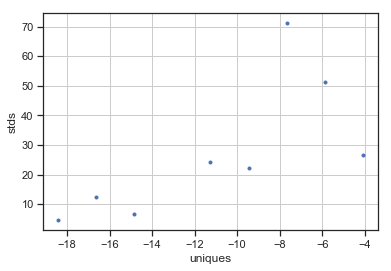

In [19]:
counts = []
stds = []
for unique in uniques:
    t = df[param+'_error'][(df[param+'_real'] == unique)]
    std = t.std()
    count = t.count()
    print(count, std)
    
    counts.append(count)
    stds.append(std)
    
plt.plot(uniques, stds, '.')
plt.grid()
plt.xlabel('uniques')
plt.ylabel('stds')

In [20]:
params

['planet_mass',
 'temp_profile',
 'ch4_mixratio',
 'planet_radius',
 'h2o_mixratio',
 'co2_mixratio',
 'co_mixratio']